In [1]:
import re
from tqdm import tqdm

import setup

In [2]:
rexp = r"Testing algorithm (?P<alg_num>\d+)\((?P<alg_name>[a-zA-Z0-9\-]+)\): \'(?P<creator>[^\']*)\' ->\'(?P<signer>[^\']*)\' -> \'(?P<verifier>[^\']*)\' \((?P<alg_size>\d+) bits\) Signature \& verify ok, create (?P<time_create_usec>\d+)usec, signature (?P<time_sign_usec>\d+)usec, verify (?P<time_verify_usec>\d+)usec"
    
raw_data = [
    re.match(rexp, l).groupdict()
    for _ in tqdm(range(10))
    for l in setup.auth("test-algorithms").split("\n") if l
]

  0%|                                                                                                                                                      | 0/10 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'pdnsutil'

In [3]:
import pandas as pd

In [4]:
data = pd.DataFrame(raw_data)
for c in ['alg_num', 'alg_size', 'time_create_usec', 'time_sign_usec', 'time_verify_usec']:
    data[c] = data[c].apply(int)
data

,alg_num,alg_name,creator,signer,verifier,alg_size,time_create_usec,time_sign_usec,time_verify_usec
0,5,RSASHA1,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,2048,128555,951,39
1,7,RSASHA1-NSEC3-SHA1,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,2048,124482,852,44
2,8,RSASHA256,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,2048,129427,953,40
3,10,RSASHA512,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,2048,122798,906,38
4,13,ECDSAP256SHA256,OpenSSL ECDSA,OpenSSL ECDSA,OpenSSL ECDSA,256,16,38,115
...,...,...,...,...,...,...,...,...,...
155,15,ED25519,Sodium ED25519,OpenSSL EDDSA,Sodium ED25519,256,35,52,96
156,15,ED25519,Sodium ED25519,Sodium ED25519,OpenSSL EDDSA,256,36,36,231
157,15,ED25519,Sodium ED25519,Sodium ED25519,Sodium ED25519,256,62,64,177
158,16,ED448,OpenSSL EDDSA,OpenSSL EDDSA,OpenSSL EDDSA,456,800,650,804


In [5]:
mdata = data.melt(
    id_vars=['alg_num', 'alg_name', 'alg_size', 'creator', 'signer', 'verifier'], 
    value_vars=['time_create_usec', 'time_sign_usec', 'time_verify_usec'], 
    value_name='duration_usec'
)
mdata

,alg_num,alg_name,alg_size,creator,signer,verifier,variable,duration_usec
0,5,RSASHA1,2048,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,time_create_usec,128555
1,7,RSASHA1-NSEC3-SHA1,2048,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,time_create_usec,124482
2,8,RSASHA256,2048,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,time_create_usec,129427
3,10,RSASHA512,2048,OpenSSL RSA,OpenSSL RSA,OpenSSL RSA,time_create_usec,122798
4,13,ECDSAP256SHA256,256,OpenSSL ECDSA,OpenSSL ECDSA,OpenSSL ECDSA,time_create_usec,16
...,...,...,...,...,...,...,...,...
475,15,ED25519,256,Sodium ED25519,OpenSSL EDDSA,Sodium ED25519,time_verify_usec,96
476,15,ED25519,256,Sodium ED25519,Sodium ED25519,OpenSSL EDDSA,time_verify_usec,231
477,15,ED25519,256,Sodium ED25519,Sodium ED25519,Sodium ED25519,time_verify_usec,177
478,16,ED448,456,OpenSSL EDDSA,OpenSSL EDDSA,OpenSSL EDDSA,time_verify_usec,804


In [6]:
mdata['action'] = mdata['variable'].apply(lambda v: v.split('_')[1])
mdata['library'] = mdata.apply(lambda row: row[{'create': 'creator', 'sign': 'signer', 'verify': 'verifier'}[row['action']]], axis=1)
mdata['library'] = mdata['library'].replace({'OpenSSL PQC': 'OQS/OpenSSL'})
mdata['library'] = mdata['library'].apply(lambda lib: lib.split(' ', 1)[0])
mdata['library'] = mdata['library'].replace({'OpenSSL': 'OQS/OpenSSL'})
mdata['algorithm'] = mdata.apply(lambda row: f"{row['alg_name']} {row['alg_size']}bits\n[{row['library']}]", axis=1)
mdata[['library', 'algorithm', 'action', 'duration_usec']]

,library,algorithm,action,duration_usec
0,OQS/OpenSSL,RSASHA1 2048bits\n[OQS/OpenSSL],create,128555
1,OQS/OpenSSL,RSASHA1-NSEC3-SHA1 2048bits\n[OQS/OpenSSL],create,124482
2,OQS/OpenSSL,RSASHA256 2048bits\n[OQS/OpenSSL],create,129427
3,OQS/OpenSSL,RSASHA512 2048bits\n[OQS/OpenSSL],create,122798
4,OQS/OpenSSL,ECDSAP256SHA256 256bits\n[OQS/OpenSSL],create,16
...,...,...,...,...
475,Sodium,ED25519 256bits\n[Sodium],verify,96
476,OQS/OpenSSL,ED25519 256bits\n[OQS/OpenSSL],verify,231
477,Sodium,ED25519 256bits\n[Sodium],verify,177
478,OQS/OpenSSL,ED448 456bits\n[OQS/OpenSSL],verify,804


In [7]:
import seaborn as sns

sns.set(font_scale=2)
sns.set_style('whitegrid')

In [8]:
ALGORITHM_COLORS = {
    'RSASHA1 2048bits\n[OQS/OpenSSL]': '#ff0000',
    'RSASHA1-NSEC3-SHA1 2048bits\n[OQS/OpenSSL]': '#dd0000',
    'RSASHA256 2048bits\n[OQS/OpenSSL]': '#bb0000',
    'RSASHA512 2048bits\n[OQS/OpenSSL]': '#990000',
    'ECDSAP256SHA256 256bits\n[OQS/OpenSSL]': '#00ff00',
    'ECDSAP384SHA384 384bits\n[OQS/OpenSSL]': '#00dd00',
    'ED25519 256bits\n[OQS/OpenSSL]': '#0000ff',
    'ED25519 256bits\n[Sodium]': '#0000dd',
    'ED448 456bits\n[OQS/OpenSSL]': '#0000bb',
    'falcon 10248bits\n[OQS/OpenSSL]': '#00ffff',
}
ALGORITHM_ORDER = list(ALGORITHM_COLORS.keys())
ALGORITHM_PALETTE = sns.color_palette([ALGORITHM_COLORS[a] for a in ALGORITHM_ORDER])

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


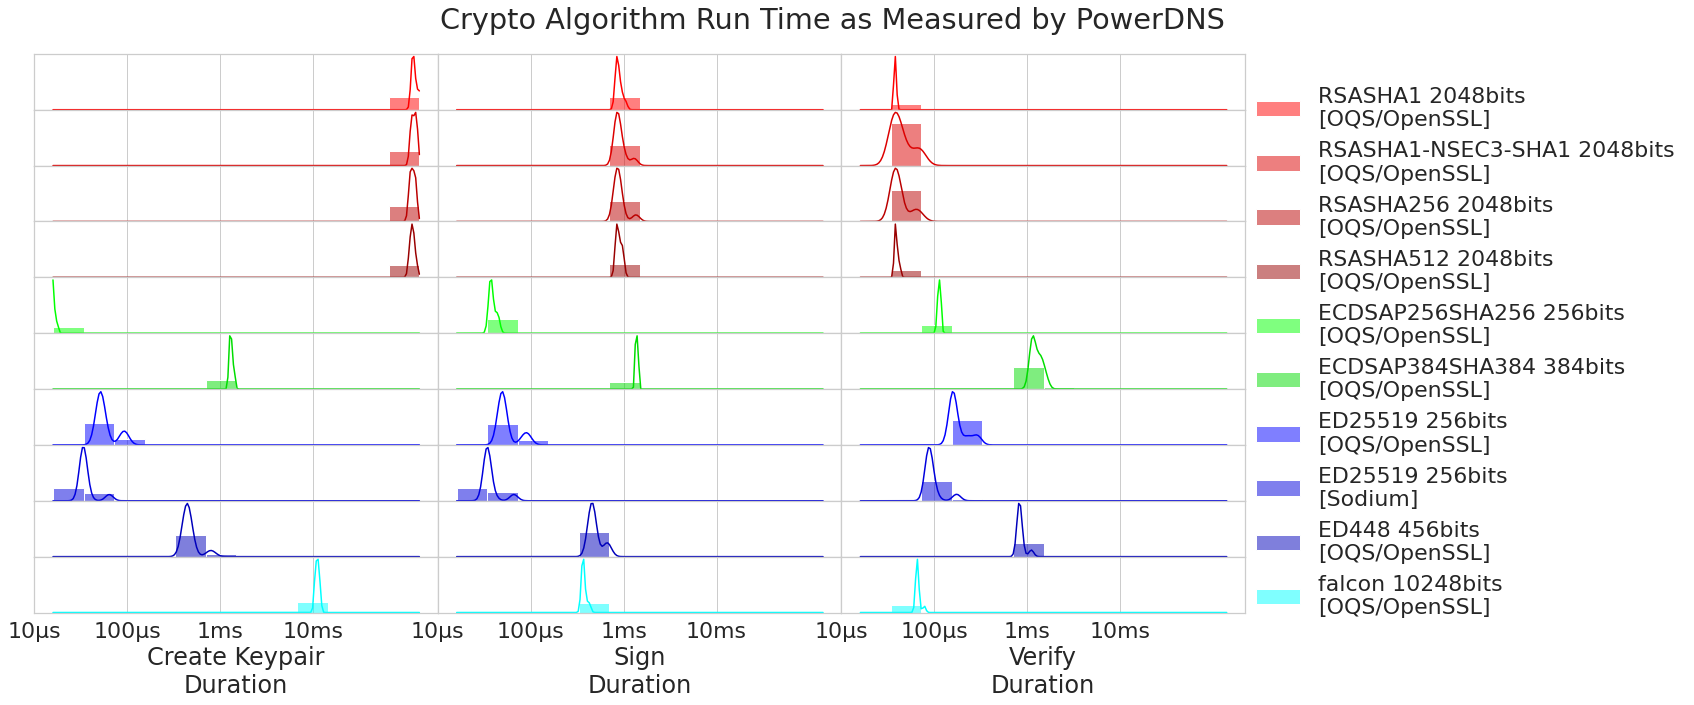

In [9]:
g = sns.displot(
    data=mdata,
    x='duration_usec',
    row='algorithm', col='action',
    hue='algorithm', hue_order=ALGORITHM_ORDER, palette=ALGORITHM_PALETTE,
    log_scale=(True, False),
    height=.9,
    aspect=6/.9,
    facet_kws=dict(legend_out=True, margin_titles=False, despine=False, sharey=False),
    kind='hist',
    kde=True,    
)
g.set(
    #xlim=(1*1e-3, 1e-1), 
    ylabel='', 
    yticks=[],
    xticks=[10, 100, 1000, 10000],
    xticklabels=["10µs", "100µs", "1ms", "10ms"],
    title='',
)

for ax, label in zip(g.axes[-1, :], ['Create Keypair', 'Sign', 'Verify']):
    ax.set_xlabel(f'{label}\nDuration')
    
g.figure.suptitle('Crypto Algorithm Run Time as Measured by PowerDNS', y=1.02)
g.figure.subplots_adjust(wspace=0, hspace=0)
g.legend.set_title('')
g.legend.set_zorder(1)
g.savefig('data/crypto_times_indv.pdf')